In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
from numpy import genfromtxt
from scipy.stats import binned_statistic
data = genfromtxt('../sample_cdip_buoy_data_BI.csv', delimiter=',')
%matplotlib widget

In [47]:
def compute_1d_spectrum(eta,dx):
    etak = fft(eta)
    Nfft = len(eta)
    k = np.fft.fftfreq(Nfft)*2*np.pi/(dx)
    # compute spectrum
    PSD=np.abs(etak)**2/Nfft**2/dk # power spectral density ( variance s / rad )
    # keep only positive frequencies
    Npos=int(Nfft/2)
    kp = k[0:Npos]
    PSD=2*PSD[0:Npos] # times two to account for the variance of the ambigous negative frequencies
    return PSD,kp  # smoothed spectrum PSDs at center wavenumber ksc
def spectrum_smooth(PSD,w,Nave):
    # Smooth the spectum by a fcator Nave (compute a bin average by a factor Nave)
    # w is the wavenumber or frquency array
    # PSD is the power spectrum
    PSDs=binned_statistic(w,PSD,bins=len(PSD)/Nave).statistic
    ws=binned_statistic(w,PSD,bins=len(PSD)/Nave).bin_edges
    wsc=(ws[0:-1:]+ws[1::])/2 # center bin
    return PSDs,wsc  # smoothed spectrum PSDs at center wavenumber wsc
def filt1d(data, window):
    """
    Smooths a 1D spectrum using a moving average filter.

    Parameters:
    data (array-like): The 1D spectral data to be smoothed.
    window_size (int): The size of the moving average window.

    Returns:
    numpy.ndarray: The smoothed 1D spectrum, with length reduced by (window_size - 1).
    
    Author: UCONN AirSea Lab, 2022
    """
    
    return np.convolve(data, window, mode='same')
    

In [3]:
t=data[1:,0]# t positions (m)
eta=data[1:,1]# surfface elevation (m)
Nfft=len(t)
taper=.5*(1 - np.cos(2*np.pi*(np.arange(0,Nfft)/(Nfft-1))))# hann

etat=eta*taper # tapered data

Fac=np.var(eta)/np.var(etat)

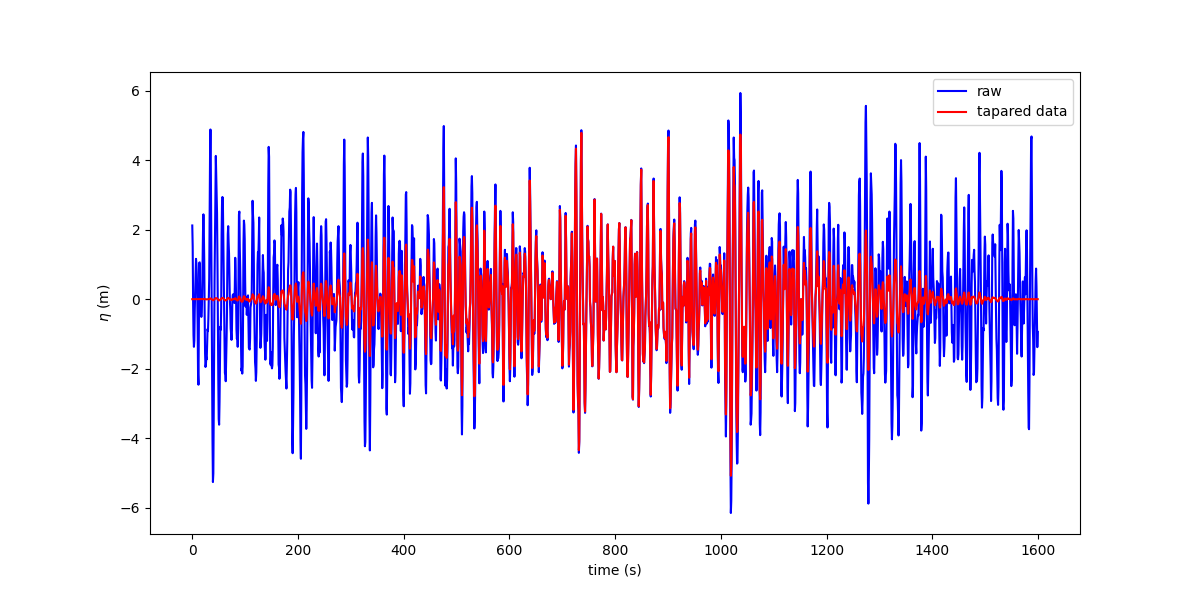

In [4]:
plt.figure(figsize = (12, 6))
plt.plot(t, eta, 'b')
plt.plot(t, etat, 'r')
plt.ylabel('$\eta$ (m)')
plt.xlabel('time (s)')
plt.legend(['raw','tapared data'])

In [18]:
# Compute spectra
T=max(t)-min(t)
dt=np.mean(np.diff(t))
Nfft=len(t)
dk=2*np.pi/T
#etak=fft(eta)#
#etakt=fft(etat)#
#w = np.fft.fftfreq(Nfft)*2*np.pi/(dt)
# compute spectrum
#PSD=np.abs(etak)**2/Nfft**2/dk
#PSDt=np.abs(etakt)**2/Nfft**2/dk # spectrum data tapered
# keep only positive frequencies
[PSD,w]=compute_1d_spectrum(eta,dt)
[PSDt,w]=compute_1d_spectrum(etat,dt)
dw=np.mean(np.diff(w));
PSDt=PSDt*Fac # correct variance lost due to taper
# check the variance
sum(PSD*dw)/sum(PSDt*dw)

np.float64(0.9999999991972781)

/var/folders/l_/gq2tr6bs2tvf1_2mzp023xr00000gn/T/ipykernel_16486/616478252.py:4: RuntimeWarning: divide by zero encountered in power
  plt.loglog(w,3e-1*w**(-4),'w')


(np.float64(0.001), np.float64(5.0), np.float64(1e-06), np.float64(100.0))

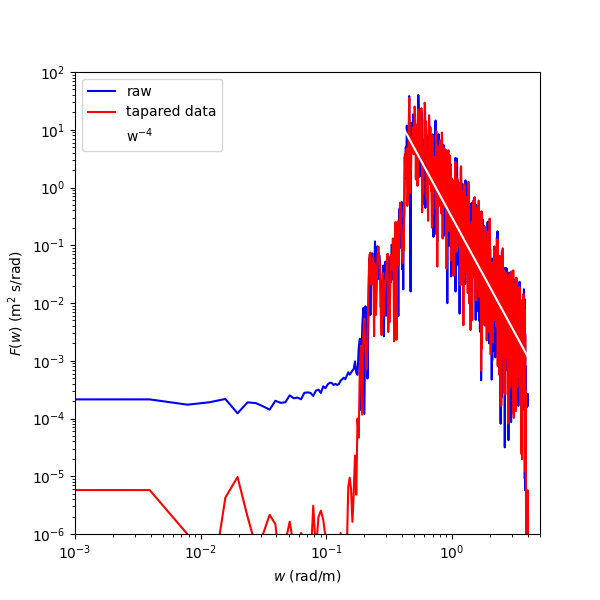

In [19]:
plt.figure(figsize = (6, 6))
plt.loglog(w, PSD, 'b')
plt.loglog(w, PSDt, 'r')
plt.loglog(w,3e-1*w**(-4),'w')
plt.xlabel('$w$ (rad/m)')
plt.ylabel('$F(w)$ (m$^2$ s/rad)')
plt.legend(['raw','tapared data','w$^{-4}$'])
plt.axis([1e-3, 5e0, 1e-6, 1e2])

In [20]:
Nave=10
# smooth the spectra by coarsening the spectrum by a factor of 10 and averaging the data in each bin.
[PSDs,wsc]=spectrum_smooth(PSD,w,Nave)
[PSDts,wsc]=spectrum_smooth(PSDt,w,Nave)
DOFs=2*Nave #degress of freedom



/var/folders/l_/gq2tr6bs2tvf1_2mzp023xr00000gn/T/ipykernel_16486/2353125698.py:5: RuntimeWarning: divide by zero encountered in power
  plt.loglog(w,3e-1*w**(-4),'c')


(np.float64(0.001), np.float64(5.0), np.float64(1e-06), np.float64(100.0))

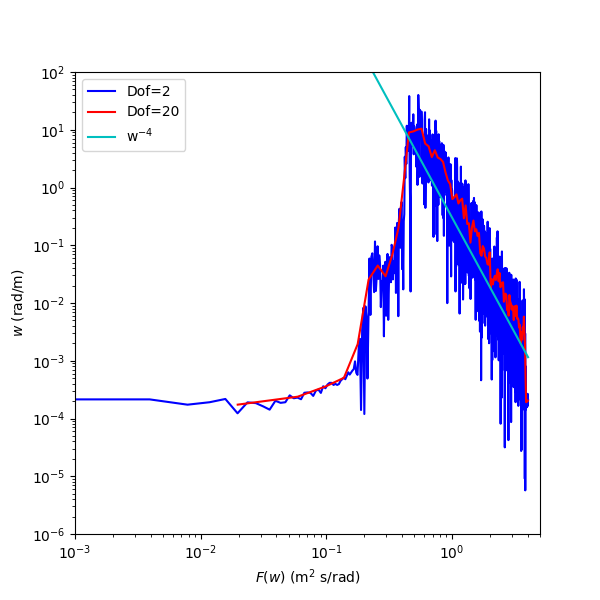

In [21]:
# 2 vs 20 DOF (w/taper)
plt.figure(figsize = (6, 6))
plt.loglog(w, PSD, 'b', label=r'$\sin (t)$')
plt.loglog(wsc, PSDs, 'r')
plt.loglog(w,3e-1*w**(-4),'c')
plt.ylabel('$w$ (rad/m)')
plt.xlabel('$F(w)$ (m$^2$ s/rad)')
plt.legend(['Dof=2','Dof=20','w$^{-4}$'])
plt.axis([1e-3, 5e0, 1e-6, 1e2])

/var/folders/l_/gq2tr6bs2tvf1_2mzp023xr00000gn/T/ipykernel_16486/2595210625.py:4: RuntimeWarning: divide by zero encountered in power
  plt.loglog(w,3e-1*w**(-4),'w')


(np.float64(0.001), np.float64(5.0), np.float64(1e-05), np.float64(100.0))

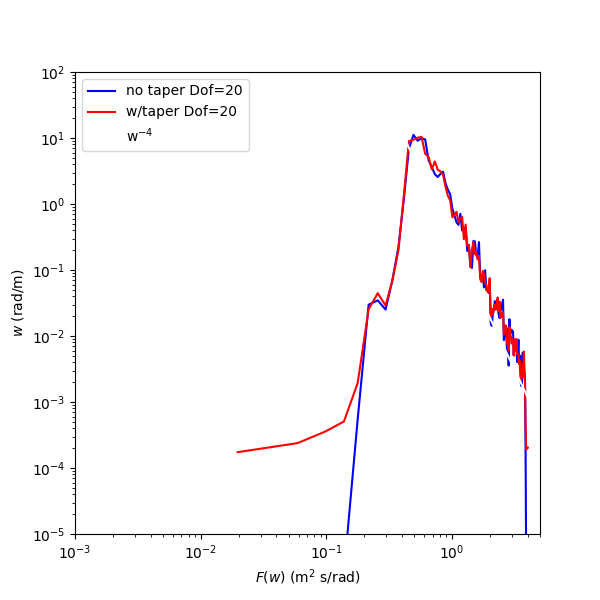

In [22]:
plt.figure(figsize = (6, 6))
plt.loglog(wsc, PSDts, 'b', label=r'$\sin (t)$')
plt.loglog(wsc, PSDs, 'r')
plt.loglog(w,3e-1*w**(-4),'w')
plt.ylabel('$w$ (rad/m)')
plt.xlabel('$F(w)$ (m$^2$ s/rad)')
plt.legend(['no taper Dof=20','w/taper Dof=20','w$^{-4}$'])
plt.axis([1e-3, 5e0, 1e-5, 1e2])

In [48]:
# add addional smoothing with a running filter

wfilt=np.ones(5);#/window_size;
DOFf=sum(wfilt);
# normalize filter
wfilt=wfilt/sum(wfilt)

PSDts2=filt1d(PSDts, wfilt);

In [50]:
DOFs2=DOFs*DOFf

np.float64(100.0)

/var/folders/l_/gq2tr6bs2tvf1_2mzp023xr00000gn/T/ipykernel_16486/802909136.py:4: RuntimeWarning: divide by zero encountered in power
  plt.loglog(w,3e-1*w**(-4),'g')


(np.float64(0.001), np.float64(5.0), np.float64(1e-05), np.float64(100.0))

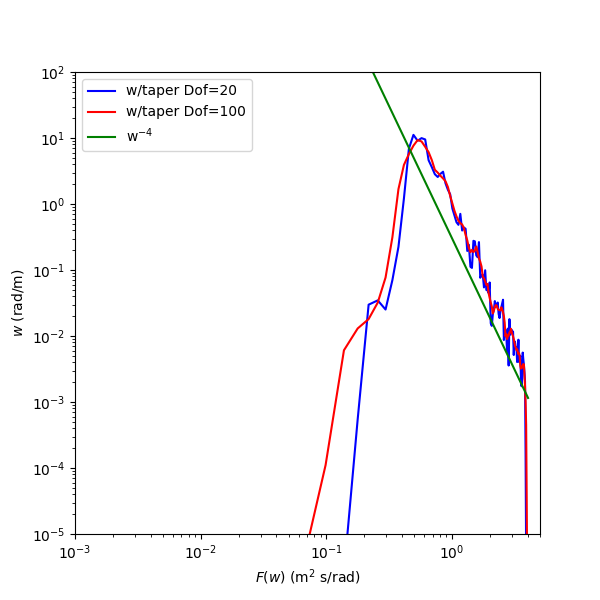

In [55]:
plt.figure(figsize = (6, 6))
plt.loglog(wsc, PSDts, 'b', label=r'$\sin (t)$')
plt.loglog(wsc, PSDts2, 'r')
plt.loglog(w,3e-1*w**(-4),'g')
plt.ylabel('$w$ (rad/m)')
plt.xlabel('$F(w)$ (m$^2$ s/rad)')
plt.legend(['w/taper Dof=20',f'w/taper Dof={int(DOFs2)}','w$^{-4}$'])
plt.axis([1e-3, 5e0, 1e-5, 1e2])

In [43]:
np.size(PSDts2)

98

In [44]:
np.size(wsc)

102

In [45]:
np.size(PSDts)

102

In [46]:
np.size(wfilt)

5